The purpose of this notebook is to take the output of RFMix and generate some nice looking figures for the Ancestry manuscript.

# Set up the environment

In [17]:
#Arguments/Parameters

working_dir = "/home/jupyter/notebooks/Ancestry"
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET')

In [18]:
#Set up the environment

#load packages
library(tidyverse)
library(reshape2)
library(ggforce)
library(stringr)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

#Make directories
system(glue::glue("
cd {working_dir}

#Create the directory to store everything
if [ ! -d '{working_dir}/ccle_ancestry_analysis' ] 
then
mkdir ccle_ancestry_analysis
fi

"))

# Load in all of the required data

In [19]:
#Download and load in the depmap cell line lineage information
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp {workspace_bucket}/depmap_cell_lineage.csv .
"))

paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
depmap.lineage = read.table("depmap_cell_lineage.csv", sep = ",", header = T)
colnames(depmap.lineage) = c("arxspan_id", "lineage_subtype")


#Download and load in a bridging file that bridges between the CDS ID and the ACH ID
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp {workspace_bucket}/ccle_sample_tracker.csv .
"))

paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
cds.to.ach = read.table("ccle_sample_tracker.csv", sep = ",", header = T)


#Load in all of the RFMix output data. The data is loaded into a list of data frames.
#The name of each element in the data frame is the name of the RFMix output file.
paste(working_dir, "/rfmix_output", sep = "") %>% setwd()
rfmix.output.file.names = list.files(path = ".", pattern = "rfmix.output.rfmix.Q")

if(rfmix.output.file.names %>% length() != 22) {
    print("Some chromosomes may be missing") } else { print("22 chromosomes were found in the rfmix output")}

rfmix.output = NULL
for(i in 1:length(rfmix.output.file.names)){
    rfmix.output[[i]] = read.table(rfmix.output.file.names[i], sep = "\t")
    colnames(rfmix.output[[i]]) = c("arxspan_id", "AFR", "AMR", "EAS", "EUR", "SAS")
}


[1] "Some chromosomes may be missing"


# Process the ancestry matrix

The purpose of this processing is to generate a matrix with the average ancestry for each cell line. This matrix will also be annotated with the ACH_ID and the lineage.

In [20]:
#Calculate the average ancestry fraction across all chromosomes


#Sum up all of the ancestry fractions
average.ancestry = NULL
for(i in 1:length(rfmix.output)){
        
    ancestry.data.subset = rfmix.output[[i]] %>%
    select(AFR, AMR, EAS, EUR, SAS)
    
    if(i == 1){
        average.ancestry = ancestry.data.subset
    } else { 
        average.ancestry = average.ancestry + ancestry.data.subset
    }
}
    


#Then divide by the number of chromosomes
average.ancestry = average.ancestry/length(rfmix.output.file.names)


#Add the sample names back in
average.ancestry = average.ancestry %>% mutate(arxspan_id = rfmix.output[[1]]$arxspan_id)

#Add in the ACH ID and the lineage information
average.ancestry = average.ancestry %>% 
inner_join(depmap.lineage, by = "arxspan_id")

#Clean up the lineage subtype column a little bit
average.ancestry$lineage_subtype = gsub("Cancer", "", average.ancestry$lineage_subtype)
average.ancestry$lineage_subtype = gsub("Non-ous", "Non-Cancerous", average.ancestry$lineage_subtype)
average.ancestry$lineage_subtype = gsub("Endometrial/Uterine", "Endometrial", average.ancestry$lineage_subtype)
average.ancestry$lineage_subtype = gsub("Head and Neck", "Head/Neck", average.ancestry$lineage_subtype)
average.ancestry$lineage_subtype = gsub("Colon/Colorectal", "Colorectal", average.ancestry$lineage_subtype)

In [21]:
#Write this plot so that we can work with it in downstream analysis
paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd()
write.table(average.ancestry, "ancestry.averages.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Now that the data is processed, let's generate a nice plot so that we can visualize the ancestry fractions

In [22]:
#Keep only the columns that we want 
average.ancestry = average.ancestry %>%
select(AFR, AMR, EAS, EUR, SAS, arxspan_id, lineage_subtype) 


#Remove the cancer types that are not that useful for our analysis
average.ancestry = average.ancestry[!average.ancestry$lineage_subtype %in% c("Engineered", "Fibroblast", "Non-Cancerous", "Teratoma"), ]


#Melt the dataframe into the format the dplyr wants
melted.average.ancestry = average.ancestry %>%
melt()


#re-adjust the column names
colnames(melted.average.ancestry) = c("arxspan_id", "lineage_subtype", "Ancestry", "value")

#And then adjust some of the variable names
original.ancestry.group = c("SAS", "AFR", "EAS", "EUR", "AMR")
new.ancestry.group = c("South Asian (SAS)", "African (AFR)", "East Asian (EAS)", "European (EUR)", "American (AMR)")
for(i in 1:length(original.ancestry.group)){
melted.average.ancestry$Ancestry = gsub(original.ancestry.group[i], new.ancestry.group[i], melted.average.ancestry$Ancestry)
}


Using arxspan_id, lineage_subtype as id variables



It will look nice to add some sort of order to the plots. Maybe one good way to do it is to first order the plots in decending order by average EUR ancestry, then average by decending order of EAS ancestry, and so on.

In [23]:
#Calculate the order in which the samples should be grouped
ordered.ancestry = average.ancestry %>% 
group_by(lineage_subtype) %>% 
summarise(AFR = mean(AFR), AMR = mean(AMR), EAS = mean(EAS), EUR = mean(EUR), SAS = mean(SAS)) %>%
arrange(-EUR)


#Get a vector that has the order
group.order = ordered.ancestry %>% select(lineage_subtype) %>% data.frame()
group.order = group.order[,1] %>% as.vector()



#Convert the lineage_subtype column of melted.average.ancestry so that it is a factor
#This should prevent ggplot2 from ordering it alphabetically
melted.average.ancestry$lineage_subtype = melted.average.ancestry$lineage_subtype %>% factor(levels = group.order)
        


#Then sort the data frame so that the rows are in the order of the vector
melted.average.ancestry = melted.average.ancestry %>%
arrange(factor(lineage_subtype, levels = group.order))


head(melted.average.ancestry)

,arxspan_id,lineage_subtype,Ancestry,value
,<chr>,<fct>,<chr>,<dbl>
1,ACH-000814,Skin,African (AFR),0.1778475
2,ACH-000644,Skin,African (AFR),0.0000000
3,ACH-000899,Skin,African (AFR),0.1858900
4,ACH-000661,Skin,African (AFR),0.1805625
5,ACH-000582,Skin,African (AFR),0.0000000
6,ACH-000274,Skin,African (AFR),0.1432175


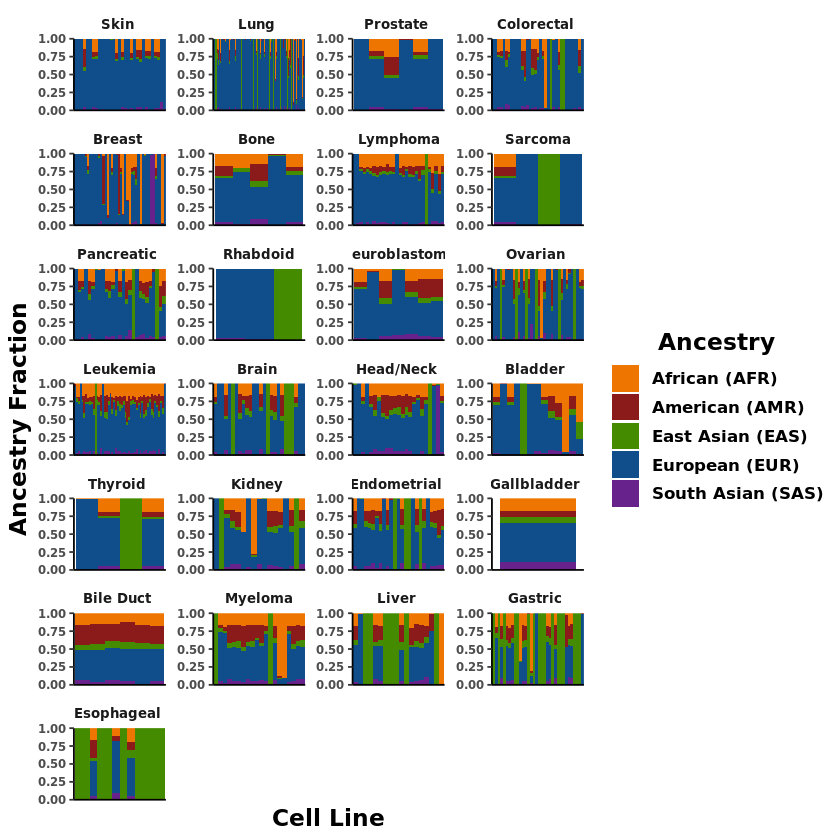

In [24]:
#Plot the plot!
melted.average.ancestry %>%
ggplot(aes(x = arxspan_id, y = value, fill = Ancestry)) +
geom_bar(stat = "Identity", width = 1) +
facet_wrap(~as.factor(lineage_subtype), scales = "free", nrow = 7, ncol = 4) +

scale_fill_manual(values = c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")) +

theme_bw() +
theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +


theme(
axis.text=element_text(size=12),
axis.title=element_text(size=14, face="bold")
) +

theme(
axis.text.x = element_text(face="bold", size=14),
axis.text.y = element_text(face="bold", size=14)
) +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

theme(
axis.text.x = element_text(size = 10),
axis.text.y = element_text(size = 7)
) +

theme(
axis.text.x=element_blank(),
axis.ticks.x=element_blank()
) +

theme(
legend.title.align=0.5
) +

theme(
strip.text = element_text(size = 8, face = "bold"),
strip.background = element_blank()
) +

scale_y_continuous(expand = c(0,0)) +

xlab("Cell Line") +
ylab("Ancestry Fraction") 

ggsave("DepMap_Ancestry_Fractions.tiff", dpi = 300, width = 10, height = 10)


#Put the exported image into the google bucket
system(glue::glue("
cd {working_dir}/ccle_ancestry_analysis
gsutil cp DepMap_Ancestry_Fractions.tiff {workspace_bucket}
"))